# SmolLM Super Weight

In [1]:
from typing import Sequence
import torch
from tqdm import tqdm

### Load model

In [2]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B"
device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)
# inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
# outputs = model.generate(inputs)
# print(tokenizer.decode(outputs[0]))

In [3]:
model.model.layers

ModuleList(
  (0-23): 24 x LlamaDecoderLayer(
    (self_attn): LlamaAttention(
      (q_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (k_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (v_proj): Linear(in_features=2048, out_features=2048, bias=False)
      (o_proj): Linear(in_features=2048, out_features=2048, bias=False)
    )
    (mlp): LlamaMLP(
      (gate_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (up_proj): Linear(in_features=2048, out_features=8192, bias=False)
      (down_proj): Linear(in_features=8192, out_features=2048, bias=False)
      (act_fn): SiLU()
    )
    (input_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
    (post_attention_layernorm): LlamaRMSNorm((2048,), eps=1e-05)
  )
)

In [4]:
num_layers = len(model.model.layers)
num_layers

24

## Super weight identification

 The method for identifying super weights is based on the finding that super weights create super activations. Super activations are exceptionally massive activations observed in LLMs that persist across many layers, have constant magnitude, and always exist at the same position regardless of input. The activation's channel aligns with the super weight's channel, and the super activation first appears right after the super weight. Pruning the super weight drastically reduces the magnitude of this massive activation, suggesting a causal link.

Super weights can be located by detecting the spikes in the inputs and outputs distributions of the `mlp.down_proj` module across different layers. This detection process is efficient and requires only a single input prompt, not a full validation dataset. First, we need to save input and output activations for each layer:

In [5]:
model.get_submodule(f"model.layers.2.mlp.down_proj")

Linear(in_features=8192, out_features=2048, bias=False)

In [6]:
#lists to store inputs and outputs activations
all_inputs = []
all_outputs = []

# Register the hook for each layer
for i in range(num_layers):
    def save_activations_hook(module, inputs, outputs):
        if isinstance(inputs, Sequence):
            inputs = inputs[0]
        all_inputs.append(inputs.cpu())
        all_outputs.append(outputs.cpu())
    layer = model.get_submodule(f"model.layers.{i}.mlp.down_proj")
    layer.register_forward_hook(save_activations_hook)

In [7]:
with torch.no_grad():
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model(inputs[:, :1])

In [8]:
len(all_inputs), len(all_outputs)

(24, 24)

Plot the extreme outliers in the input and output activations of the mlp.down_proj module for all transformer layers

In [9]:
max_input_activations = [inp_act.abs().max().item() for inp_act in all_inputs]
max_output_activations = [out_act.abs().max().item() for out_act in all_outputs]

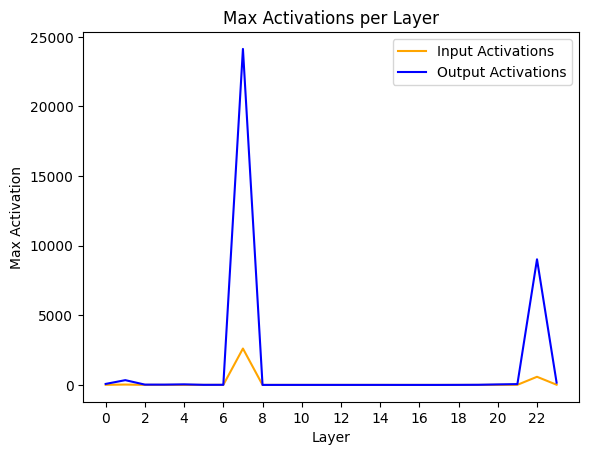

In [10]:
import matplotlib.pyplot as plt

plt.plot(max_input_activations, label="Input Activations", color="orange")
plt.plot(max_output_activations, label="Output Activations", color="blue")
plt.xlabel("Layer")
plt.ylabel("Max Activation")
plt.title("Max Activations per Layer")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see that super activations first appear after layer 1 output So, the super weight must be in layer 1. Lets find it!

Specifically, for a given layer, the channel index of the large maximum-magnitude activation in the down_proj input indicates the row of the super weight.
The channel index of the large maximum-magnitude activation in the down_proj output in the same layer indicates the column of the super weight.

In [11]:
all_outputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[342.2404]]),
indices=tensor([[749]]))

In [12]:
all_inputs[1].abs().max(dim=-1)

torch.return_types.max(
values=tensor([[26.4583]]),
indices=tensor([[4987]]))

So the super weight is [749, 4987] of mlp down_proj from layer 1. Lets check that it actually is a super weight by looking at the activations it produces in each layer.

In [13]:
super_activations = [abs(act[0, -1, 749]) for act in all_outputs]


/tmp/ipykernel_504/3639201231.py:6: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


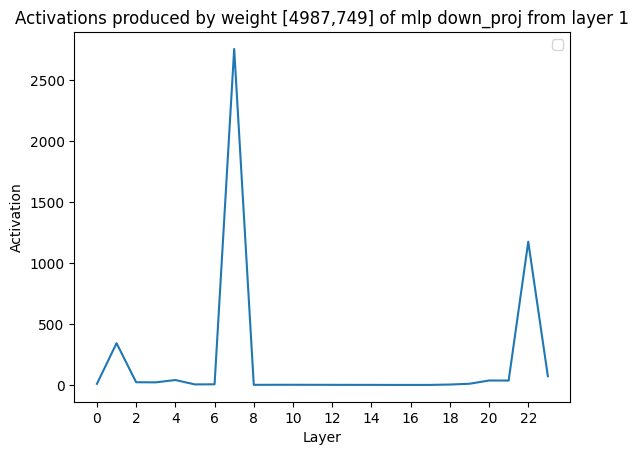

In [14]:
plt.plot(super_activations)
plt.xlabel("Layer")
plt.ylabel("Activation")
plt.title("Activations produced by weight [4987,749] of mlp down_proj from layer 1")
plt.xticks(range(0, num_layers, 2))
plt.legend()
plt.show()

We can see from that output activations produced by the weight [749, 4987] of mlp down_proj from layer 1 are match to maximum output activations from plot above.

## Calculate perplexity on Wiki-2

In [15]:
inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
outputs = model.generate(inputs)
print(f"Initial output: {tokenizer.decode(outputs[0])}")
super_wight_value = model.model.layers[1].mlp.down_proj.weight[749, 4987].item()
with torch.no_grad():
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    inputs = tokenizer.encode("Transformer architecture is", return_tensors="pt").to(device)
    outputs = model.generate(inputs)
    print(f"Output with weight [4987,749] set to 0: {tokenizer.decode(outputs[0])}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:0 for open-end generation.


Initial output: Transformer architecture is a type of neural network that is used for unsupervised learning. It is a type of neural network that
Output with weight [4987,749] set to 0: Transformer architecture isControlPlane of <jupyter_script>./. . . . . . . . . . . . . . .


In [16]:
from datasets import load_dataset

test = load_dataset("wikitext", "wikitext-2-raw-v1", split="test")[:400] # use subset of data to prevent out of memery error
encodings = tokenizer("\n\n".join(test["text"]), return_tensors="pt")

Token indices sequence length is longer than the specified maximum sequence length for this model (33269 > 8192). Running this sequence through the model will result in indexing errors


In [17]:
max_length = 8192
stride = 4086
seq_len = encodings.input_ids.size(1)
max_length, stride, seq_len



(8192, 4086, 33269)

In [18]:
from tqdm import tqdm

def calculate_perplexity(model, encodings):
    nll_sum = 0.0
    n_tokens = 0
    prev_end_loc = 0

    # calculations are based on https://huggingface.co/docs/transformers/en/perplexity#example-calculating-perplexity-with-gpt-2-in--transformers
    for begin_loc in tqdm(range(0, seq_len, stride)):
        end_loc = min(begin_loc + max_length, seq_len)
        trg_len = end_loc - prev_end_loc  # may be different from stride on last loop

        input_ids = encodings.input_ids[:, begin_loc:end_loc].to(device)
        target_ids = input_ids.clone()
        target_ids[:, :-trg_len] = -100
    
        with torch.no_grad():
            outputs = model(input_ids, labels=target_ids)

            neg_log_likelihood = outputs.loss # loss is calculated using CrossEntropyLoss which averages over valid labels
    
        # Accumulate the total negative log-likelihood and the total number of tokens
        num_valid_tokens = (target_ids != -100).sum().item()  # number of valid tokens in target_ids
        batch_size = target_ids.size(0)
        num_loss_tokens = num_valid_tokens - batch_size  # subtract batch_size due to internal label shift
        nll_sum += neg_log_likelihood * num_loss_tokens
        n_tokens += num_loss_tokens

        prev_end_loc = end_loc
        del input_ids
        if end_loc == seq_len:
            break
    avg_nll = nll_sum / n_tokens  # average negative log-likelihood per token
    ppl = torch.exp(avg_nll)
    return ppl.item()

In [19]:
with torch.no_grad():
    ppl=calculate_perplexity(model, encodings)
    print(f"Initial perplexity: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    ppl = calculate_perplexity(model, encodings)
    print(f"Perplexity with weight [4987,749] set to 0: {ppl}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value

 78%|███████▊  | 7/9 [00:34<00:09,  4.97s/it]


Initial perplexity: 6.766842365264893


 78%|███████▊  | 7/9 [00:34<00:09,  4.97s/it]

Perplexity with weight [4987,749] set to 0: 41784044.0


In [20]:
del encodings
del test
del model
torch.cuda.empty_cache()

## Instruct model evaluation

In [21]:
from transformers import AutoModelForCausalLM, AutoTokenizer
checkpoint = "HuggingFaceTB/SmolLM2-1.7B-Instruct"

device = "cuda" # for GPU usage or "cpu" for CPU usage
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
# for multiple GPUs install accelerate and do `model = AutoModelForCausalLM.from_pretrained(checkpoint, device_map="auto")`
model = AutoModelForCausalLM.from_pretrained(checkpoint).to(device)

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/655 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/908 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.42G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/132 [00:00<?, ?B/s]

In [22]:
messages = [{"role": "user", "content": "What is the capital of France."}]
input_text=tokenizer.apply_chat_template(messages, tokenize=False)
inputs = tokenizer.encode(input_text, return_tensors="pt").to(device)
outputs = model.generate(inputs, max_new_tokens=50, temperature=0.2, top_p=0.9, do_sample=True)
print(tokenizer.decode(outputs[0]))

<|im_start|>system
You are a helpful AI assistant named SmolLM, trained by Hugging Face<|im_end|>
<|im_start|>user
What is the capital of France.<|im_end|>
<|im_start|>assistant
The capital of France is Paris.<|im_end|>


### Hellaswag dataset

In [23]:
from datasets import load_dataset

dataset = load_dataset("hellaswag", split="validation")

README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001.parquet:   0%|          | 0.00/24.4M [00:00<?, ?B/s]

data/test-00000-of-00001.parquet:   0%|          | 0.00/6.11M [00:00<?, ?B/s]

data/validation-00000-of-00001.parquet:   0%|          | 0.00/6.32M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/39905 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10003 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [24]:
# code from https://github.com/pchizhov/hellaswag-evaluation/blob/main/evaluation_scripts/evaluate_generation.py
import torch
import json
import re
import datasets
import random


def preprocess(text):
    text = text.strip()
    # NOTE: Brackets are artifacts of the WikiHow dataset portion of HellaSwag.
    text = text.replace(" [title]", ". ")
    text = re.sub("\[.*?\]", "", text)
    text = text.replace("  ", " ")
    return text


def process_docs(dataset: datasets.Dataset, eval_type='full') -> datasets.Dataset:
    def _process_doc(doc):
        if eval_type == 'full':
            ctx = doc["ctx_a"] + " " + doc["ctx_b"].capitalize()
        else:
            ctx = doc["ctx_b"].capitalize()
        choices = [preprocess(ending) for ending in doc["endings"]]
        gold_index = int(doc["label"])

        indices = list(range(len(choices)))
        random.shuffle(indices)
        shuffled_choices = [choices[i] for i in indices]
        new_gold_index = indices.index(gold_index)

        if eval_type == 'full':
            query = preprocess(doc["activity_label"] + ": " + ctx)
        else:
            query = preprocess(ctx)

        out_doc = {
            "query": query,
            "choices": shuffled_choices,
            "gold": new_gold_index,
        }
        return out_doc

    return dataset.map(_process_doc)


def construct_prompt(context, endings):
    prompt = (
        "You are given a situation followed by four possible endings. "
        "Choose the most appropriate ending by selecting the corresponding number. "
        "Respond only with the number of the correct answer.\n\n"
        f"Context: {context}\n"
    )
    for i, ending in enumerate(endings):
        prompt += f"{i + 1}. {ending}\n"
    prompt += "\nAnswer: "
    return prompt


def generate_answer(prompt):
    inputs = tokenizer(prompt, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model.generate(**inputs, max_length=inputs.input_ids.shape[1] + 2)
    answer = tokenizer.decode(outputs[0], skip_special_tokens=True).strip()
    return answer.split("Answer:")[-1].strip()


def compute_real_accuracy(filename):
    with open(filename, "r") as f:
        data = json.load(f)

    correct = 0
    for question in data:
        digits = [a for a in question['generated_answer'] if a in '1234']
        if len(digits) == 0:
            print('ERROR:', question)
        else:
            correct += int(digits[0] == question['correct_answer'])

    return correct / len(data)

<>:13: SyntaxWarning: invalid escape sequence '\['
<>:13: SyntaxWarning: invalid escape sequence '\['
/tmp/ipykernel_504/3337459041.py:13: SyntaxWarning: invalid escape sequence '\['
  text = re.sub("\[.*?\]", "", text)


In [25]:
dataset = process_docs(dataset)



def evaluate():
    correct = 0
    total = len(dataset)
    results = []
    for i in tqdm(range(total)):
        example = dataset[i]
        context = example["query"]
        endings = example["choices"]
        correct_answer = str(example["gold"] + 1)  # Labels are 0-indexed
        prompt = construct_prompt(context, endings)
        generated_answer = generate_answer(prompt)

        results.append({
            "context": context,
            "options": endings,
            "correct_answer": correct_answer,
            "generated_answer": generated_answer
        })

        if correct_answer == generated_answer:
            correct += 1

    accuracy = correct / total
    print(f"Initial Accuracy: {accuracy:.2%}")

    filename = f"data/hellaswag_SmalLM2.json"

    with open(filename, "w") as f:
        json.dump(results, f, indent=4)


    real_accuracy = compute_real_accuracy(filename)
    print(f"Real Accuracy: {real_accuracy:.2%}")
    return real_accuracy

Map:   0%|          | 0/10042 [00:00<?, ? examples/s]

In [ ]:
with torch.no_grad():
    print(f"Initial accuracy: {evaluate()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = 0
    print(f"Accuracy with weight [4987,749] set to 0: {evaluate()}")
    model.model.layers[1].mlp.down_proj.weight[749, 4987] = super_wight_value


100%|██████████| 10042/10042 [05:29<00:00, 30.52it/s]


Initial Accuracy: 10.03%
ERROR: {'context': 'Sharpening knives: A man is holding a pocket knife while sitting on some rocks in the wilderness. Then he', 'options': ['sand the rocks and tops them by using strong pressure.', 'uses the knife to shave his leg.', 'opens a can of oil put oil on the knife, and puts oil on a knife and press it through a can filled with oil then cuts several pieces from the sandwiches.', 'takes a small stone from the flowing river and smashes it on another stone.'], 'correct_answer': '4', 'generated_answer': '('}
ERROR: {'context': 'Sharpening knives: Then he takes a small stone from the flowing river and smashes it on another stone. He starts to crush the small stone to smaller pieces. He', 'options': ['eventually brings it back into view and adds it to the smaller ones to make a small triangular shaped piece.', 'cuts the center stone in half and blow it on to make it bigger.', 'grind it hard to make the pieces smaller.', 'starts to party with them and throw t

100%|██████████| 10042/10042 [06:20<00:00, 26.41it/s]


Initial Accuracy: 0.00%
ERROR: {'context': 'Washing face: A black female is shown in a room with a black scarf around her head. Black spots on her faced are then zoomed in on and she begins to apply something on it. Next', 'options': [', she takes some spray and it makes her skin extremely oily and she continues to talk until the video is over.', ', she is shown making multiple moans and sprays some kind of liquid down her face before hanging up.', 'she is shown in various different locations and gets extremely close to a wall.', ', she begins to brush her lips and make painted lips look just like a lipstick to the camera and ends with her closing gift and instruction showing her off at the end.'], 'correct_answer': '1', 'generated_answer': 'end of'}
ERROR: {'context': 'Gargling mouthwash: A young boy and girl are standing over a sink with their mother talking. The mother', 'options': ['shows some shaving cream on the boy who is scrubbing her brushes.', 'instructs them on how to brush 